# FKE pour le chemostat

On écrit le modèle du chemostat:
\begin{align*}
\dot X(t) &= f(X(t)) + \sigma \,\xi(t)\\
Y_k  &= h(X(t_k)) + V_k
\end{align*}
sous forme canonique en posant:
\begin{align*}
X=\begin{pmatrix} S\\ B\end{pmatrix}=\begin{pmatrix} x_1\\ x_2\end{pmatrix}
\end{align*}
On écrit $f$:
\begin{align*}
  f(X) = f(S,B) = 
  \begin{pmatrix}  D\,(S_{in}-S)-\kappa\,\mu(S)\,B         \\ (\mu(S)-D)\,B \end{pmatrix} = 
  \begin{pmatrix}  D\,(S_{in}-x_1)-\kappa\,\mu(x_1)\,x_2   \\ (\mu(x_1)-D)\,x_2 \end{pmatrix}
\end{align*}
et son gradient:
\begin{align*}
  \nabla f(X) =
  \begin{pmatrix}  -D-\kappa\,\mu'(S)\,B     & -\kappa\,\mu(S)   \\  \mu'(S)\,B     & \mu(S)-D   \end{pmatrix} =   
  \begin{pmatrix}  -D-\kappa\,\mu'(x_1)\,x_2 & -\kappa\,\mu(x_1) \\  \mu'(x_1)\,x_2 & \mu(x_1)-D \end{pmatrix}  
\end{align*}
De même $h$:
\begin{align*}
   h(X) = h(S,B) = \mu(S)\,B=\mu(x_1)\,x_2
\end{align*}
et son gradient:
\begin{align*}
   \nabla h(X) = \nabla h(S,B)  =  
   \begin{pmatrix}  \mu'(S)\,B      & \mu(S)  \end{pmatrix} = 
   \begin{pmatrix}  \mu'(x_1)\,x_2  & \mu(x_1) \end{pmatrix}
\end{align*}
où
\begin{align*}
   \mu(S) =   \mu_{max}\,\frac{S}{K+S} =   \mu_{max}\,\frac{x_1}{K+x_1} 
\end{align*}
et
\begin{align*}
   \mu'(S) =   \mu_{max}\,\frac{(K+S)\,S'-(K+S)'\,S}{(K+S)^2} =   \mu_{max}\,\frac{K}{(K+S)^2} =
    \mu_{max}\,\frac{K}{(K+x_1)^2}
\end{align*}

## Les fonctions

On définit toutes les fonctions $f(x)$,  $\nabla f(x)$,  $h(x)$,  $\nabla h(x)$

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


smin, smax = 0, 3 
bmin, bmax = 0, 1.5
ka      = 2;    # stoichiometric coefficient
s_in    = 2.4;  # input substrate concentration
D       = 0.1;  # dillution rate
mu_max  = 5;    # maximim of the specific rate (Monod case)
k_s     = 10;   # half saturation coeficient   (Monod case)
T       = 50    # temps final

Sigma = np.array([ [1, 0],[0, 1] ])
Qxi   = np.array([ [0.0001, 0], [0, 0.0001] ])
Qv    = 0.0001

EX0 = np.array([1.8 , 0.15]).reshape((2, 1))
VX0 = np.array([1, 0, 0, 1]).reshape((2, 2))

def f(x, t):
    "second memnbre de l'EDO chemostat"
    mu = mu_max*x[0]/(k_s+x[0])
    f1 = D*(s_in-x[0])-ka*mu*x[1]
    f2 = (mu-D)*x[1]
    return f1,f2

def Df(x):
    "differentielle second memnbre de l'EDO chemostat"
    denom = k_s+x[0]
    mu    = mu_max*x[0]/denom
    mu    = mu_max*k_s/(denom*denom)
    D1f1  = -D-ka*mup*x[1]
    D2f1  = -ka*mu
    D1f2  = mup*x[1]
    D2f2  = mu-D
    return D1f1,D2f1,D1f2,D2f2

def h(x):
    "fonction observation"
    mu = mu_max*x[0]/(k_s+x[0])
    return mu*x[1]

def Dh(x):
    "differentielle fonction observation"
    denom = k_s+x[0]
    mu    = mu_max*x[0]/denom
    mup   = mu_max*k_s/(denom*denom)
    return mup*x[1],mu


def f_etendu(x_etendu, t):
    '''second membre étendu : 
    EDO chemostat couplé à l'EDO de Riccati pour FKE'''
    x     = x_etendu[0:2].reshape((2,1))   # unpacking du couple (etat,Cov) 
    cov   = x_etendu[2:6].reshape((2,2))   #        -------
    denom = k_s+x[0]
    mu    = mu_max*x[0]/denom
    mup   = mu_max*k_s/(denom*denom)
    f1    = D*(s_in-x[0])-ka*mu*x[1]
    f2    = (mu-D)*x[1]
    D1f1  = -D-ka*mup*x[1]
    D2f1  = -ka*mu
    D1f2  = mup*x[1]
    D2f2  = mu-D
    DF    = np.array([D1f1, D2f1, D1f2, D2f2]).reshape((2, 2))
    Fcov = DF*cov+cov.transpose()*DF.transpose()+Sigma*Qxi*Sigma.transpose()
    "attention je retourne deux fois Fcov[1,0]"
    return [f1, f2, Fcov[0,0], Fcov[1,0], Fcov[1,0], Fcov[1,1]]

In [46]:
"pour mémo:"
x_etendu = np.array([1,2,3,4,5,6])
x        = x_etendu[0:2].reshape((2,1))
cov      = x_etendu[2:6].reshape((2, 2)) 
print("x =",x)
print("cov =",cov)

x = [[1]
 [2]]
cov = [[3 4]
 [5 6]]


## Simulation du système à espace d'état



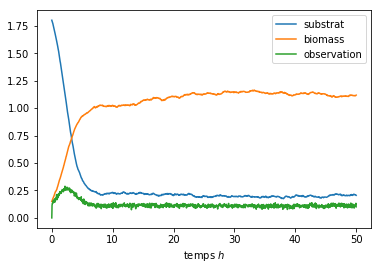

In [48]:
# SIMULATION
t_obs = np.linspace(0, T, 1201)  # pas d'observation en t_obs[0]=0 

S0 = EX0[0]  # subtrat initiale
B0 = EX0[1]  # biomasse initiale

S = np.ones_like(t_obs)
B = np.ones_like(t_obs)
Y = np.ones_like(t_obs)
S[0] , B[0] = S0, B0
Y[0] = 0 # dummy value
i = 0
delta = t_obs[1]
i_max = len(t_obs)
sq0 = np.sqrt(Qxi[0,0]*delta)
sq1 = np.sqrt(Qxi[1,1]*delta)
for i in range(i_max-1):
    fS, fB = f([S[i],B[i]], 0)
    S[i+1] = S[i] + delta * fS + sq0*np.random.randn()
    B[i+1] = B[i] + delta * fB + sq1*np.random.randn()
    Y[i+1] = h([S[i+1],B[i+1]]) + np.sqrt(Qv)*np.random.randn()

plt.plot(t_obs,S,label='substrat')    
plt.plot(t_obs,B,label='biomass')    
plt.plot(t_obs,Y,label='observation')    
plt.xlabel(r'temps $h$')
plt.legend()
plt.show()